# A Lightweight Concept Drift Detection and Adaptation Framework for IoT Data Streams
This is the code for the paper entitled "**A Lightweight Concept Drift Detection and Adaptation Framework for IoT Data Streams**" accepted in IEEE Internet of Things Magazine.  
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

**Notebook 3: Proposed Optimized Adaptive and Sliding Windowing (OASW) method for concept drift detection and adaptation**  
Aims:  
&nbsp; 1): Develop a drift detection and adaptation method to handle concept drift   
&nbsp; 2): Obtain the optimized drift model using hyperparameter optimization techniques  

## Import libraries

In [1]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#!pip install river==0.19.0
!pip install memory-profiler
#!pip install Optunity

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from river import metrics
from river import stream
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Read the NSL-KDD dataset

In [7]:
# df = pd.read_csv("NSL_KDD_binary(train+test).csv")
# df1 = pd.read_csv("NSL_KDD_binary_train.csv")
# df2 = pd.read_csv("NSL_KDD_binary_test.csv")
df1 = pd.read_csv("/content/drive/MyDrive/NSL_KDD_binary_train.csv")
df2 = pd.read_csv("/content/drive/MyDrive/NSL_KDD_binary_test.csv")
df = pd.read_csv("/content/drive/MyDrive/NSL_KDD_binary(train+test).csv")

### Data sampling
Use the last 10% of training set and the entire test set

In [8]:
df_used = int(len(df1)*0.1) + len(df2)
df0 = df.iloc[-df_used:]

# df0=df0.sample(n=None, frac=0.1, replace=False, weights=None, random_state=None, axis=0)
# df0=df0.sort_index()

In [9]:
df0

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
113376,0,0,0,0,1132,366,0,0,0,0,...,148,0.88,0.08,0.03,0.01,0.00,0.0,0.00,0.00,0
113377,0,0,0,0,256,3123,0,0,0,0,...,255,1.00,0.00,0.01,0.02,0.00,0.0,0.00,0.00,0
113378,1,1,1,1,2215,333,0,0,0,0,...,99,0.39,0.08,0.00,0.00,0.02,0.0,0.00,0.00,0
113379,0,0,0,0,0,0,0,0,0,0,...,1,0.00,0.07,0.00,0.00,1.00,1.0,0.00,0.00,1
113380,0,0,0,0,0,0,0,0,0,0,...,1,0.00,0.08,0.00,0.00,1.00,1.0,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,0,0,0,0,794,333,0,0,0,0,...,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,0
148513,0,0,0,0,317,938,0,0,0,0,...,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,0
148514,0,0,0,0,54540,8314,0,0,0,2,...,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,1
148515,0,0,0,0,42,42,0,0,0,0,...,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0


## Train-test split
10% training set, and 90% test set

In [10]:
X = df0.drop(['label'],axis=1)
y = df0['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.1, test_size = 0.9, shuffle=False, random_state = 0)

## Offline learning: LightGBM

In [12]:
%%time
import memory_profiler as mem_profile
m1 = mem_profile.memory_usage()
print('Memory (Before): ' + str(m1[0]) + ' MB' )

classifier = lgb.LGBMClassifier()
# classifier = joblib.load('Optimized_lightGBM.pkl')
classifier.fit(X_train,y_train)
predictions = classifier.predict(X_test)
print("Accuracy: "+str(accuracy_score(y_test,predictions)))
print("Precision: "+str(precision_score(y_test,predictions)))
print("Recall: "+str(recall_score(y_test,predictions)))
print("F1-Score: "+str(f1_score(y_test,predictions)))


m2 = mem_profile.memory_usage()
print('Memory (After) : ' + str(m2[0]) + ' MB')
print('Memory Consumption : ' + str(m2[0]-m1[0]) + ' MB')

Memory (Before): 436.96875 MB
[LightGBM] [Info] Number of positive: 1599, number of negative: 1915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 3514, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455037 -> initscore=-0.180339
[LightGBM] [Info] Start training from score -0.180339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy: 0.8507920447718721
Precision: 0.9775836747313906
Recall: 0.740630124150855
F1-Score: 0.8427681338086829
Memory (After) : 441.20703125 MB
Memory Consumption : 4.23828125 MB
CPU times: user 526 ms, sys: 10.2 ms, total: 536 ms
Wall time: 846 ms


# OASW method Development

## Define the OASW method

In [13]:
import time
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

# a: warining threshold, b: drift threshold, win1: sliding window size, win2: adaptive window max size
def oasw_bo(params):

    a=abs(float(params['a']))
    b=abs(float(params['b']))
    win1=int(params['win1'])
    win2=int(params['win2'])

    i=0
    yt = []
    yp = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]

    metric = metrics.Accuracy()

    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, int(y_pred[0]))  # update the metric

        # Store the y_test, y_pred, and x_test
        yt.append(yi)
        yp.append(y_pred)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:])
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)
            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1
    score=metric.get()
    print(str(a)+" "+str(b)+" "+str(win1)+" "+str(win2)+" "+str(score)) # Output the hyperparameter values and corresponding accuracy
    return {'loss': -score, 'status': STATUS_OK }


## Hyperparameter optimization by BO-TPE

In [14]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
space = {
    'a': hp.quniform('a', 0.95, 0.99, 0.001),
    'b': hp.quniform('b', 0.90, 0.98, 0.001),
    'win1': hp.quniform('win1', 200, 1000, 50),
    'win2': hp.quniform('win2', 1000, 5000, 100),
}

t1=time.time()
best = fmin(fn=oasw_bo,
            space=space,
            algo=tpe.suggest,
            max_evals=10)
print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print(t2-t1)

[LightGBM] [Info] Number of positive: 1599, number of negative: 1915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 3514, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455037 -> initscore=-0.180339
[LightGBM] [Info] Start training from score -0.180339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 225, number of negative: 226
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in t

## Hyperparameter optimization by PSO

In [15]:
def oasw(a=0.99, b=0.95, win1=200, win2=1000):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    i=0
    yt = []
    yp = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]

    metric = metrics.Accuracy()

    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, int(y_pred[0]))  # update the metric

        # Store the y_test, y_pred, and x_test
        yt.append(yi)
        yp.append(y_pred)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:])
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)
            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1
    score=metric.get()
    print(str(a)+" "+str(b)+" "+str(win1)+" "+str(win2)+" "+str(score)) # Output the hyperparameter values and corresponding accuracy
    return score

In [16]:
import optunity
import optunity.metrics

search = {
    'a': [0.95,0.99],
    'b': [0.90,0.98],
    'win1': [200,1000],
    'win2': [1000,5000],
         }

optimal_configuration, info, _ = optunity.maximize(oasw,
                                                  solver_name='particle swarm',
                                                  num_evals=10,
                                                   **search
                                                  )
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

[LightGBM] [Info] Number of positive: 1599, number of negative: 1915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 3514, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455037 -> initscore=-0.180339
[LightGBM] [Info] Start training from score -0.180339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 106, number of negative: 140
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 396
[LightGBM] [Info] Number of data points in t

## Train the optimized OASW model with optimal hyperparameters
The accuracy change figure is also plotted

In [25]:
# Define OASW with a figure
def oasw_plot(a=0.99, b=0.95, win1=200, win2=1000):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    metric = metrics.Accuracy()
    metric2 = metrics.Accuracy()

    i = 0
    t = []
    yt = []
    yp = []
    m = []
    m2 = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]

    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)

    classifier2 = lgb.LGBMClassifier() # Train an offline LightGBM model as a comparison model
    classifier2.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, int(y_pred[0]))  # update the metric

        y_pred2= classifier2.predict(xi2.reshape(1, -1))
        metric2 = metric2.update(yi, int(y_pred2[0]))

        # Store the y_test, y_pred, x_test, and real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        m2.append(metric2.get()*100)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:])
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)

            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1

    # Plot the accuracy change figure
    plt.rcParams.update({'font.size': 35})
    plt.ion()
    plt.figure(1,figsize=(24,15))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(t,m,'-b',label='OASW+LightGBM, Avg Accuracy: %.2f%%'%(metric.get()*100))
    plt.plot(t,m2,'red',label='Offline LightGBM, Avg Avg Accuracy: %.2f%%'%(metric2.get()*100))

    #Plot the drift points
    for i in range(len(dr)):
        if i!=0:
            plt.scatter(dr[i],m[dr[i]],s=200,c='r')

    plt.legend(loc='best')
    plt.ylim(80, 101)
    plt.title('NSL-KDD', fontsize=40)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy(%)')

    plt.draw()

[LightGBM] [Info] Number of positive: 1599, number of negative: 1915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 3514, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455037 -> initscore=-0.180339
[LightGBM] [Info] Start training from score -0.180339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1599, number of negative: 1915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points i

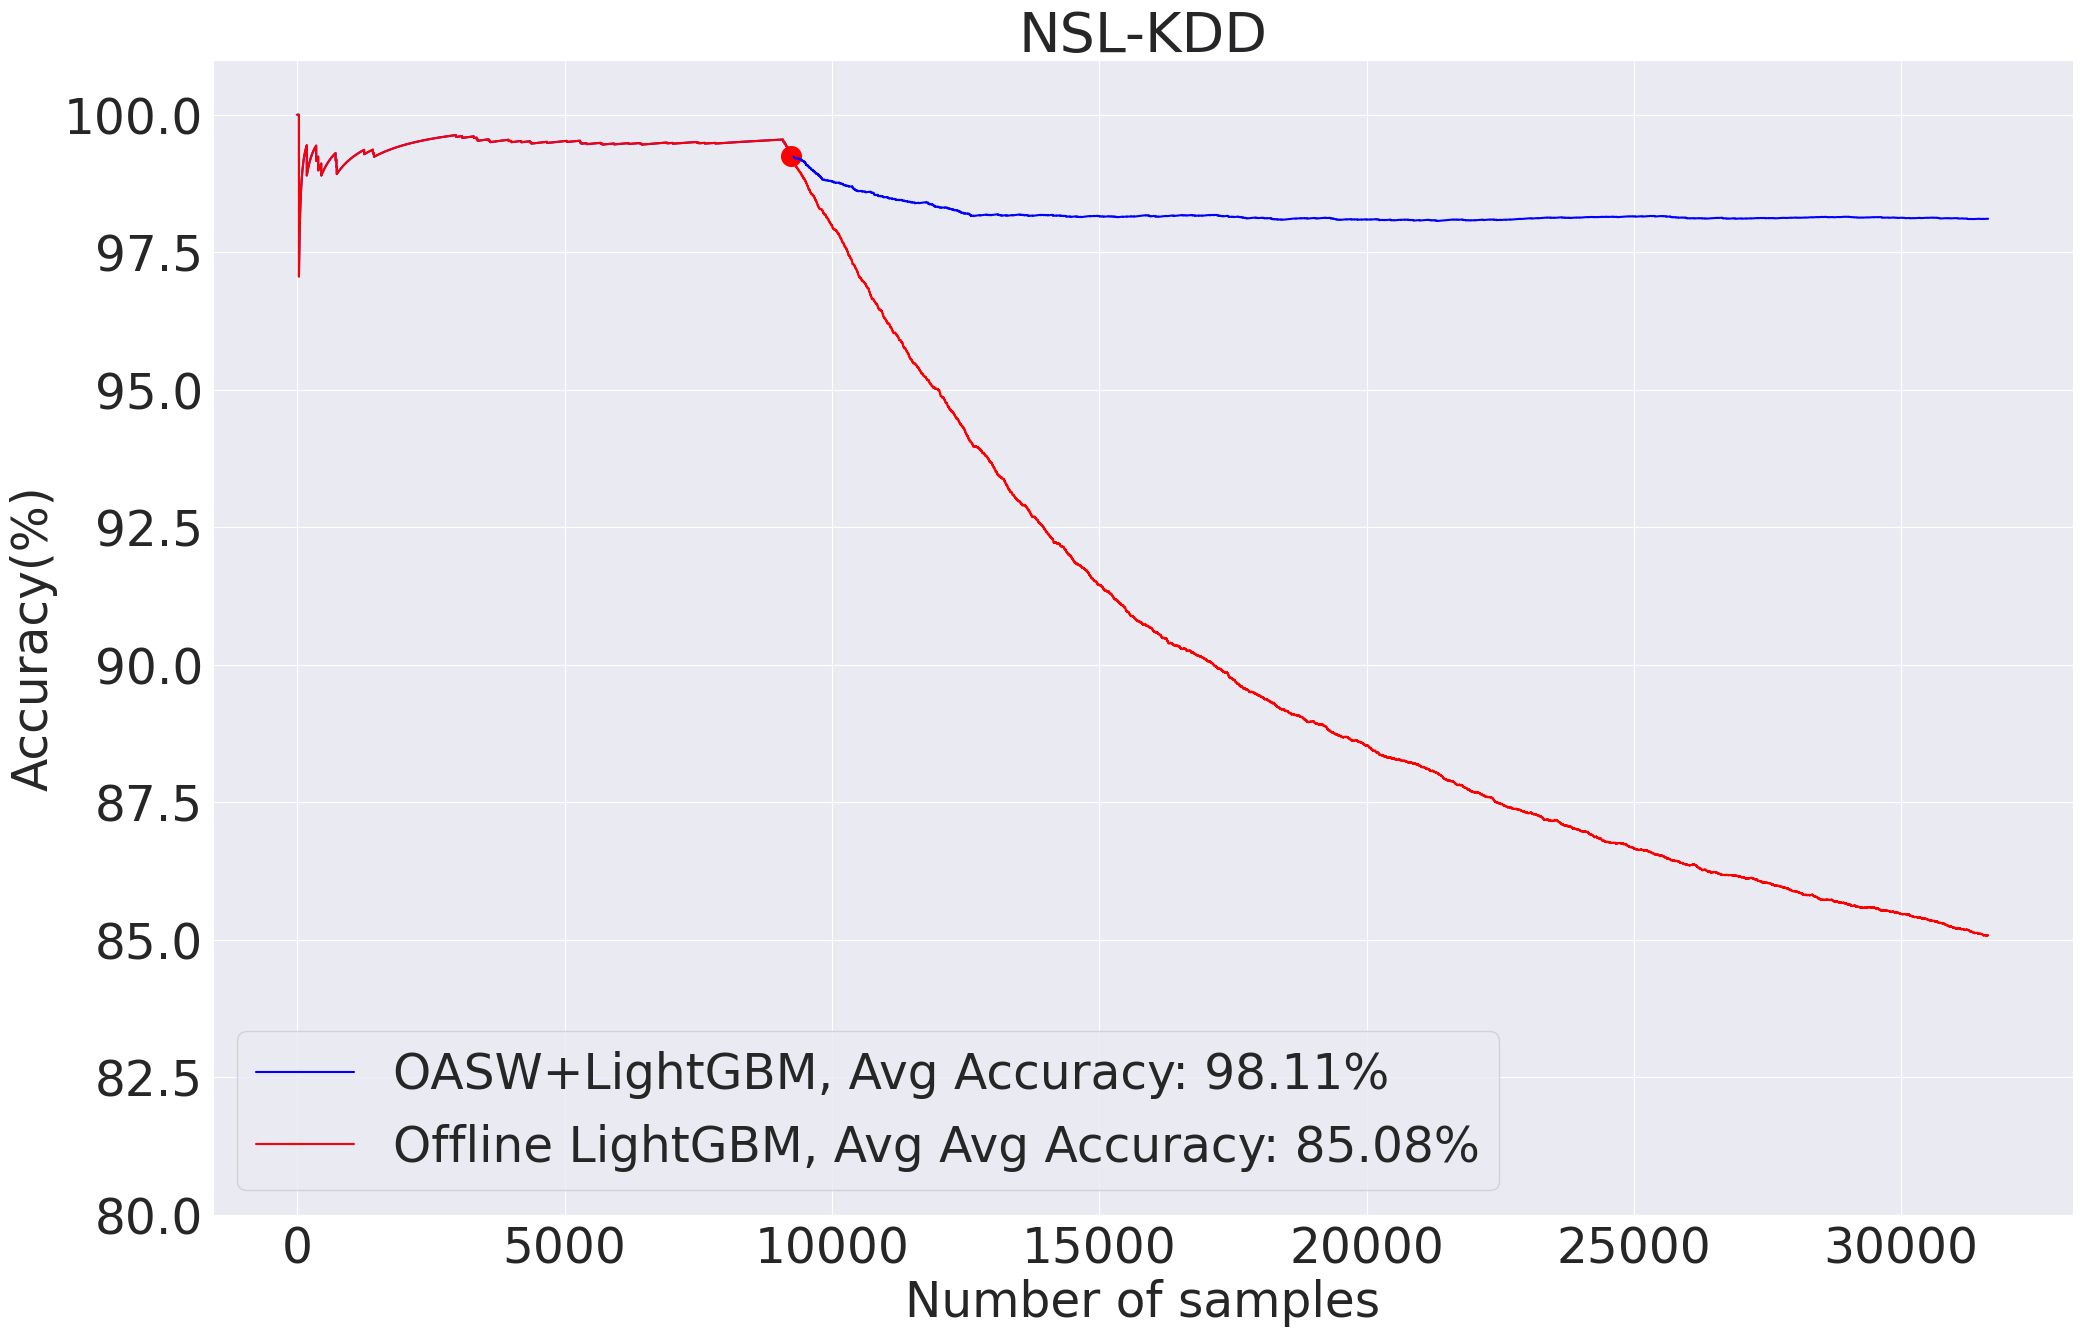

In [26]:
# Assign the optimal hyperparameters detected by PSO
oasw_plot(a = 0.96509765625, b = 0.9200390625, win1 = 344, win2 = 3521)

In [27]:
# Define OASW with a figure
def oasw_plot(a=0.99, b=0.95, win1=200, win2=1000):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    metric = metrics.Precision()
    metric2 = metrics.Precision()

    i = 0
    t = []
    yt = []
    yp = []
    m = []
    m2 = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]

    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)

    classifier2 = lgb.LGBMClassifier() # Train an offline LightGBM model as a comparison model
    classifier2.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, int(y_pred[0]))  # update the metric

        y_pred2= classifier2.predict(xi2.reshape(1, -1))
        metric2 = metric2.update(yi, int(y_pred2[0]))

        # Store the y_test, y_pred, x_test, and real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        m2.append(metric2.get()*100)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:])
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)

            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1

    # Plot the accuracy change figure
    plt.rcParams.update({'font.size': 35})
    plt.ion()
    plt.figure(1,figsize=(24,15))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(t,m,'-b',label='OASW+LightGBM, Avg Precision: %.2f%%'%(metric.get()*100))
    plt.plot(t,m2,'red',label='Offline LightGBM, Avg Avg Precision: %.2f%%'%(metric2.get()*100))

    #Plot the drift points
    for i in range(len(dr)):
        if i!=0:
            plt.scatter(dr[i],m[dr[i]],s=200,c='r')

    plt.legend(loc='best')
    plt.ylim(80, 101)
    plt.title('NSL-KDD', fontsize=40)
    plt.xlabel('Number of samples')
    plt.ylabel('Precision(%)')

    plt.draw()

[LightGBM] [Info] Number of positive: 1599, number of negative: 1915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 3514, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455037 -> initscore=-0.180339
[LightGBM] [Info] Start training from score -0.180339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1599, number of negative: 1915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points i

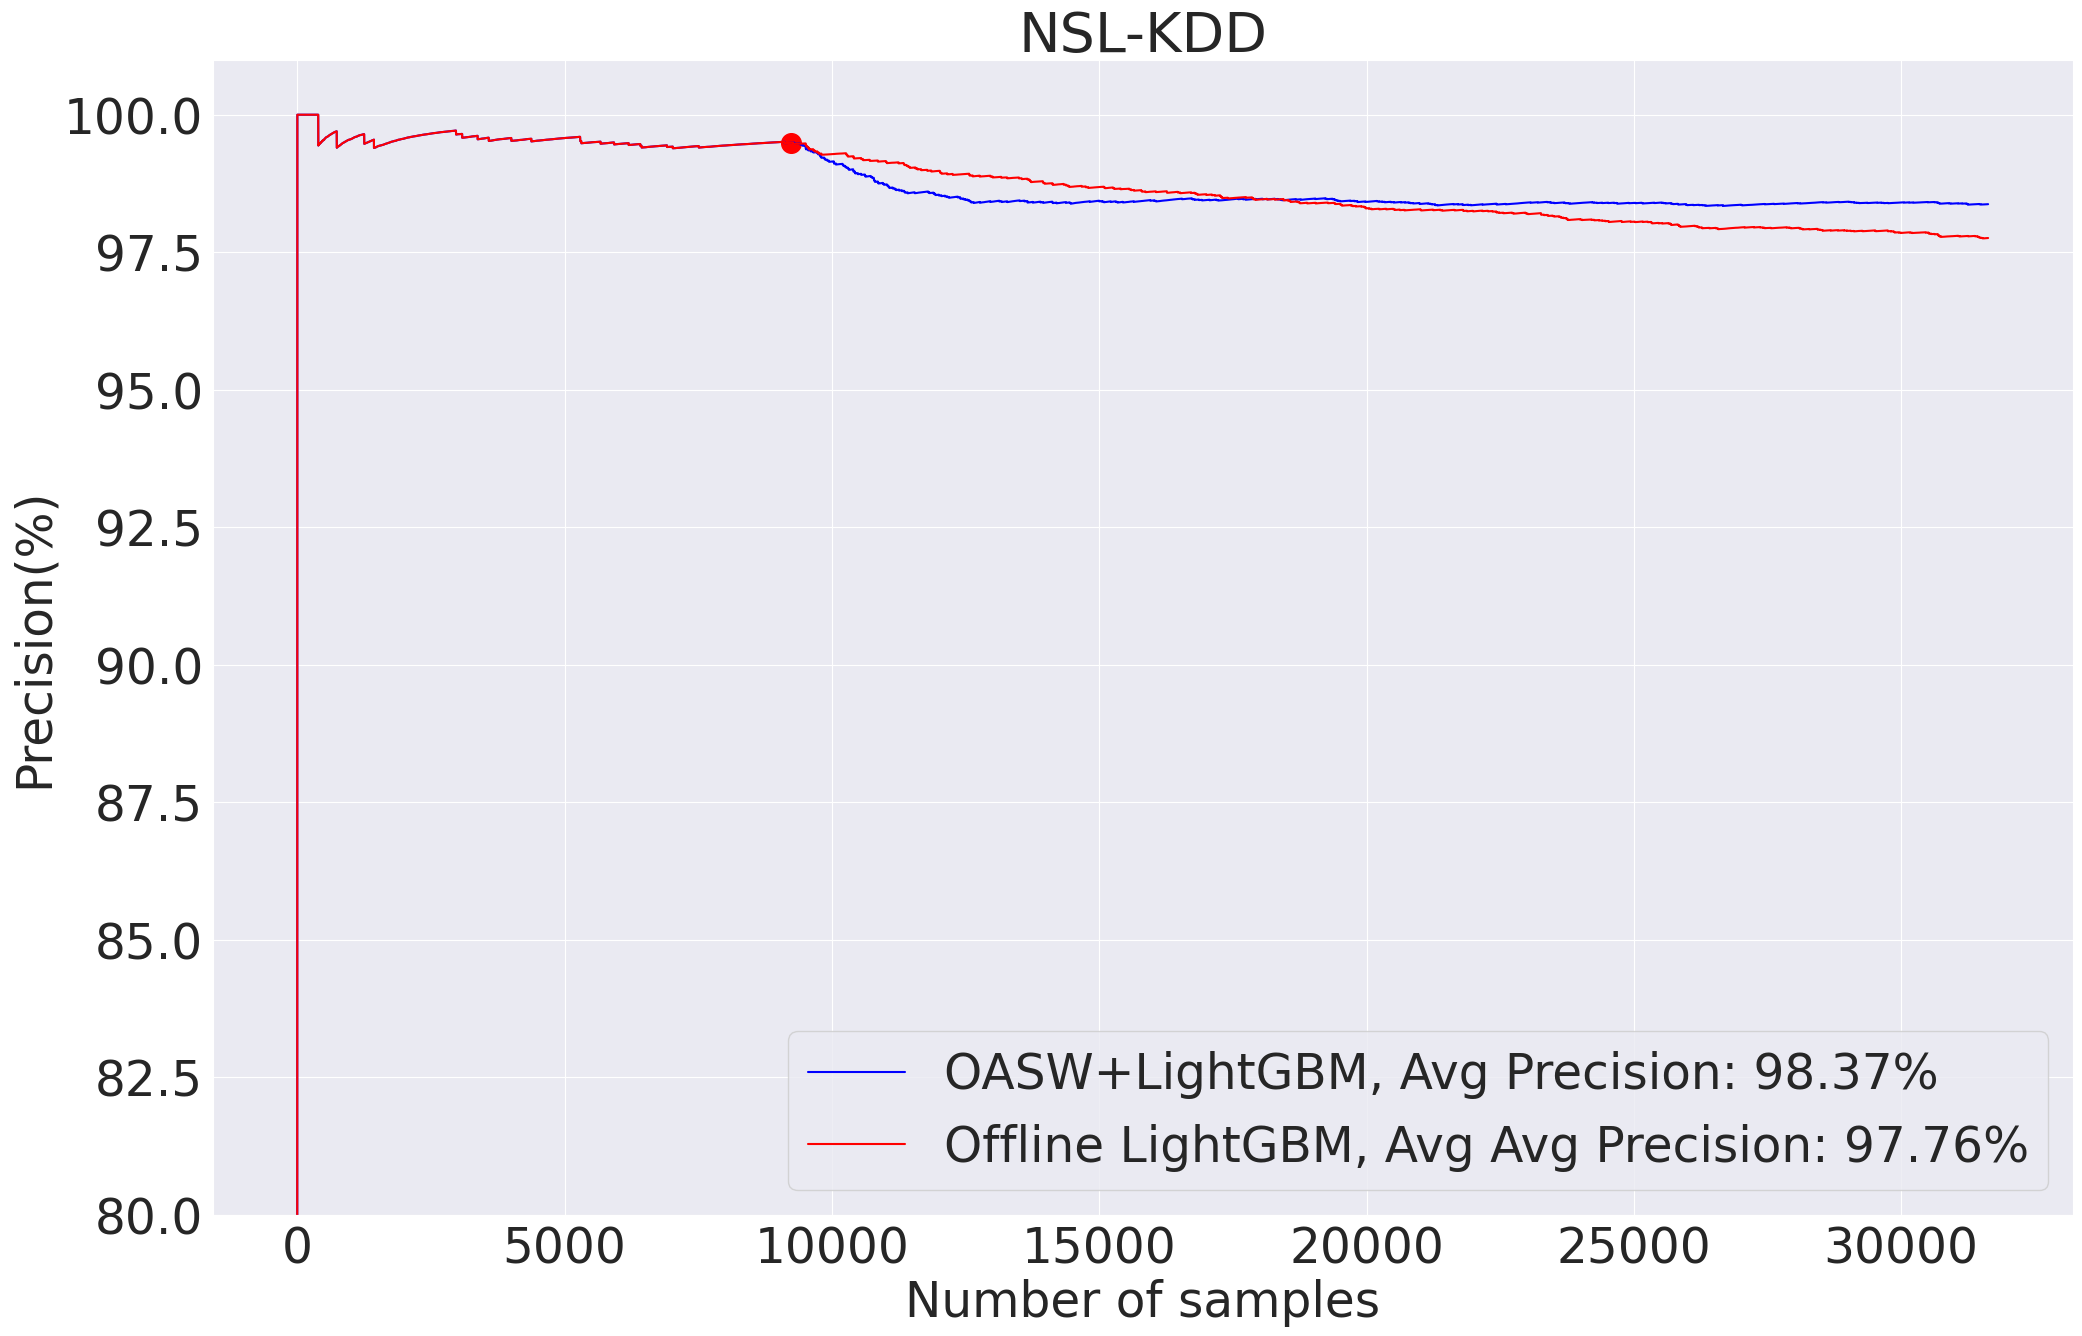

In [28]:
# Assign the optimal hyperparameters detected by PSO
oasw_plot(a = 0.96509765625, b = 0.9200390625, win1 = 344, win2 = 3521)

In [33]:
# Define OASW with a figure
def oasw_plot(a=0.99, b=0.95, win1=200, win2=1000):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    metric = metrics.Recall()
    metric2 = metrics.Recall()

    i = 0
    t = []
    yt = []
    yp = []
    m = []
    m2 = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]

    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)

    classifier2 = lgb.LGBMClassifier() # Train an offline LightGBM model as a comparison model
    classifier2.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, int(y_pred[0]))  # update the metric

        y_pred2= classifier2.predict(xi2.reshape(1, -1))
        metric2 = metric2.update(yi, int(y_pred2[0]))

        # Store the y_test, y_pred, x_test, and real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        m2.append(metric2.get()*100)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:])
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)

            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1

    # Plot the accuracy change figure
    plt.rcParams.update({'font.size': 35})
    plt.ion()
    plt.figure(1,figsize=(24,15))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(t,m,'-b',label='OASW+LightGBM, Avg Recall: %.2f%%'%(metric.get()*100))
    plt.plot(t,m2,'red',label='Offline LightGBM, Avg Avg Recall: %.2f%%'%(metric2.get()*100))

    #Plot the drift points
    for i in range(len(dr)):
        if i!=0:
            plt.scatter(dr[i],m[dr[i]],s=200,c='r')

    plt.legend(loc='best')
    plt.ylim(70, 101)
    plt.title('NSL-KDD', fontsize=40)
    plt.xlabel('Number of samples')
    plt.ylabel('Recall(%)')

    plt.draw()

[LightGBM] [Info] Number of positive: 1599, number of negative: 1915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 3514, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455037 -> initscore=-0.180339
[LightGBM] [Info] Start training from score -0.180339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1599, number of negative: 1915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points i

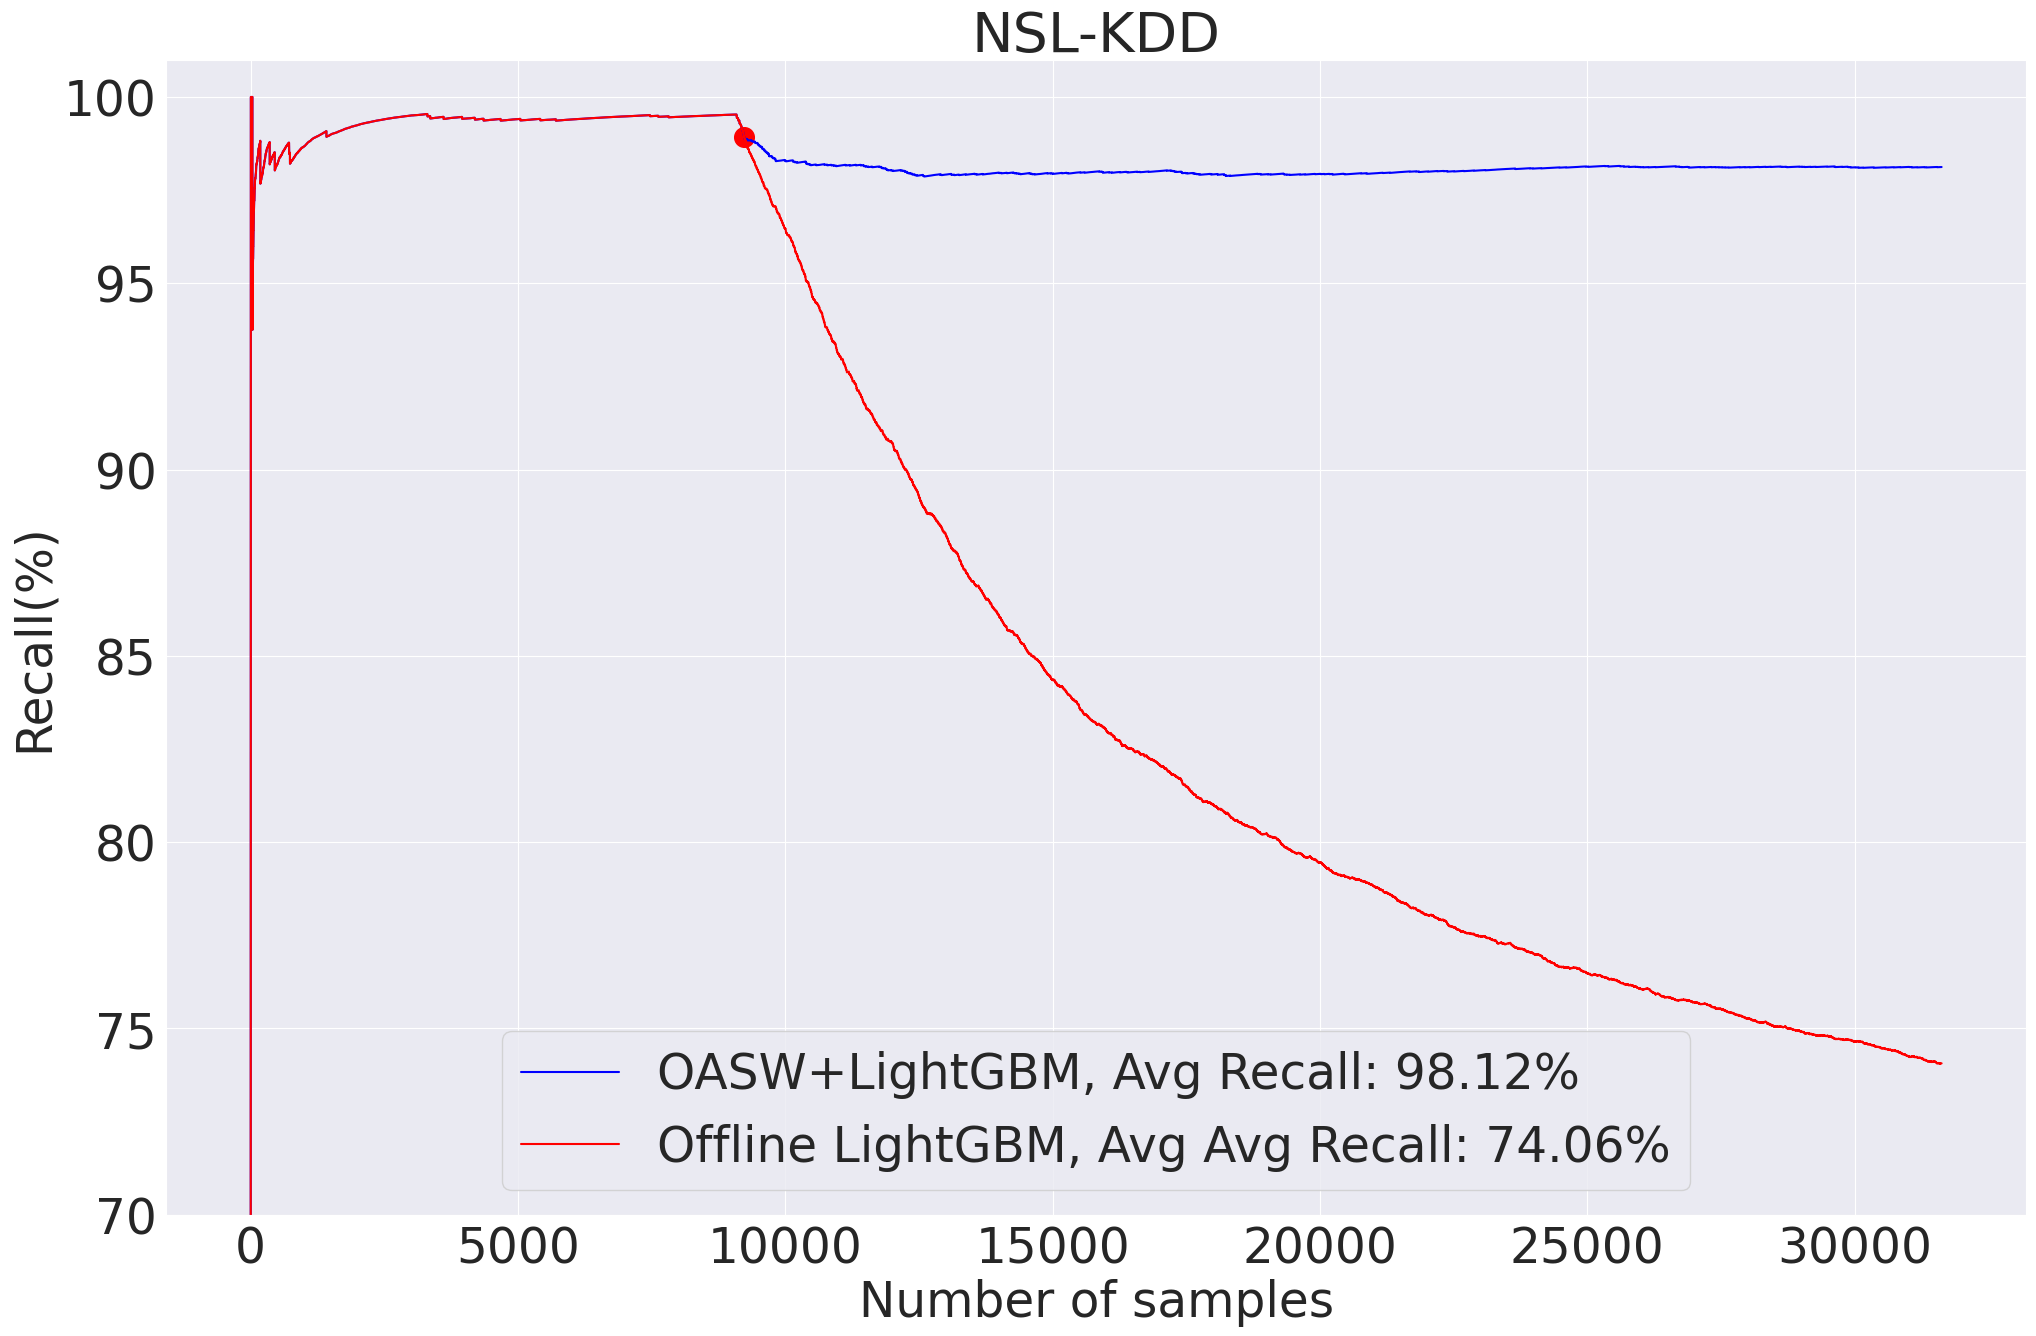

In [34]:
# Assign the optimal hyperparameters detected by PSO
oasw_plot(a = 0.96509765625, b = 0.9200390625, win1 = 344, win2 = 3521)

In [31]:
# Define OASW with a figure
def oasw_plot(a=0.99, b=0.95, win1=200, win2=1000):
    a = round(a, 3)
    b = round(b, 3)
    win1 = round(win1)
    win2 = round(win2)

    metric = metrics.F1()
    metric2 = metrics.F1()

    i = 0
    t = []
    yt = []
    yp = []
    m = []
    m2 = []
    x_new=[]
    y_new=[]
    dr=[0]
    d=0
    f=0
    tt=0
    th=0
    xt=[]

    classifier = lgb.LGBMClassifier() # Train the initial LightGBM model
    classifier.fit(X_train,y_train)

    classifier2 = lgb.LGBMClassifier() # Train an offline LightGBM model as a comparison model
    classifier2.fit(X_train,y_train)

    for xi, yi in stream.iter_pandas(X_test, y_test):

        xi2=np.array(list(xi.values()))
        y_pred = classifier.predict(xi2.reshape(1, -1))      # make a prediction
        metric = metric.update(yi, int(y_pred[0]))  # update the metric

        y_pred2= classifier2.predict(xi2.reshape(1, -1))
        metric2 = metric2.update(yi, int(y_pred2[0]))

        # Store the y_test, y_pred, x_test, and real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        m2.append(metric2.get()*100)
        xt.append(xi2)

        # Monitor the accuracy changes in the sliding window
        if i>2*win1:
            acc1=accuracy_score(yt[i-win1:],yp[i-win1:]) # Current window accuracy
            acc2=accuracy_score(yt[i-2*win1:i-win1],yp[i-2*win1:i-win1]) # Last window accuracy
            if (d==0)&(acc1<a*acc2): # If the window accuracy drops to the warning level
                x_new.append(xi2)
                y_new.append(yi)
                d=1
            if d==1: # In the warning level
                tt=len(y_new)
                if acc1<b*acc2: # If the window accuracy drops to the drift level
                    dr.append(i)# Record the drift start point
                    f=i
                    if tt<win1: # if enough new concept samples are collected
                        classifier.fit(xt[i-win1:],yt[i-win1:])
                    else:
                        classifier.fit(x_new,y_new)
                    d=2
                elif (acc1>a*acc2)|(tt==win2): # If the window accuracy increases back to the normal level (false alarm)
                    x_new=[]
                    y_new=[]
                    d=0
                else:
                    x_new.append(xi2)
                    y_new.append(yi)

            if d==2: # In the drift level
                tt=len(y_new)
                acc3=accuracy_score(yt[f:f+win1],yp[f:f+win1])
                x_new.append(xi2)
                y_new.append(yi)
                if tt>=win1:
                    if (acc1<a*acc3): # When new concept accuracy drops to the warning level
                        if th==0:
                            classifier.fit(x_new,y_new) # Retrain the classifier on all the newly collected samples to obtain a robust classifier
                            th=1
                    if (th==1)&(tt==win2): # When sufficient new concept samples are collected
                        classifier.fit(x_new,y_new) #obtain a robust classifier
                        x_new=[]
                        y_new=[]
                        d=0 # Go back to the normal state for next potential drift detection
                        th=0

        i=i+1

    # Plot the accuracy change figure
    plt.rcParams.update({'font.size': 35})
    plt.ion()
    plt.figure(1,figsize=(24,15))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(t,m,'-b',label='OASW+LightGBM, Avg F1-Score: %.2f%%'%(metric.get()*100))
    plt.plot(t,m2,'red',label='Offline LightGBM, Avg Avg F1-Score: %.2f%%'%(metric2.get()*100))

    #Plot the drift points
    for i in range(len(dr)):
        if i!=0:
            plt.scatter(dr[i],m[dr[i]],s=200,c='r')

    plt.legend(loc='best')
    plt.ylim(80, 101)
    plt.title('NSL-KDD', fontsize=40)
    plt.xlabel('Number of samples')
    plt.ylabel('F1-Score(%)')

    plt.draw()

[LightGBM] [Info] Number of positive: 1599, number of negative: 1915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 3514, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455037 -> initscore=-0.180339
[LightGBM] [Info] Start training from score -0.180339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1599, number of negative: 1915
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points i

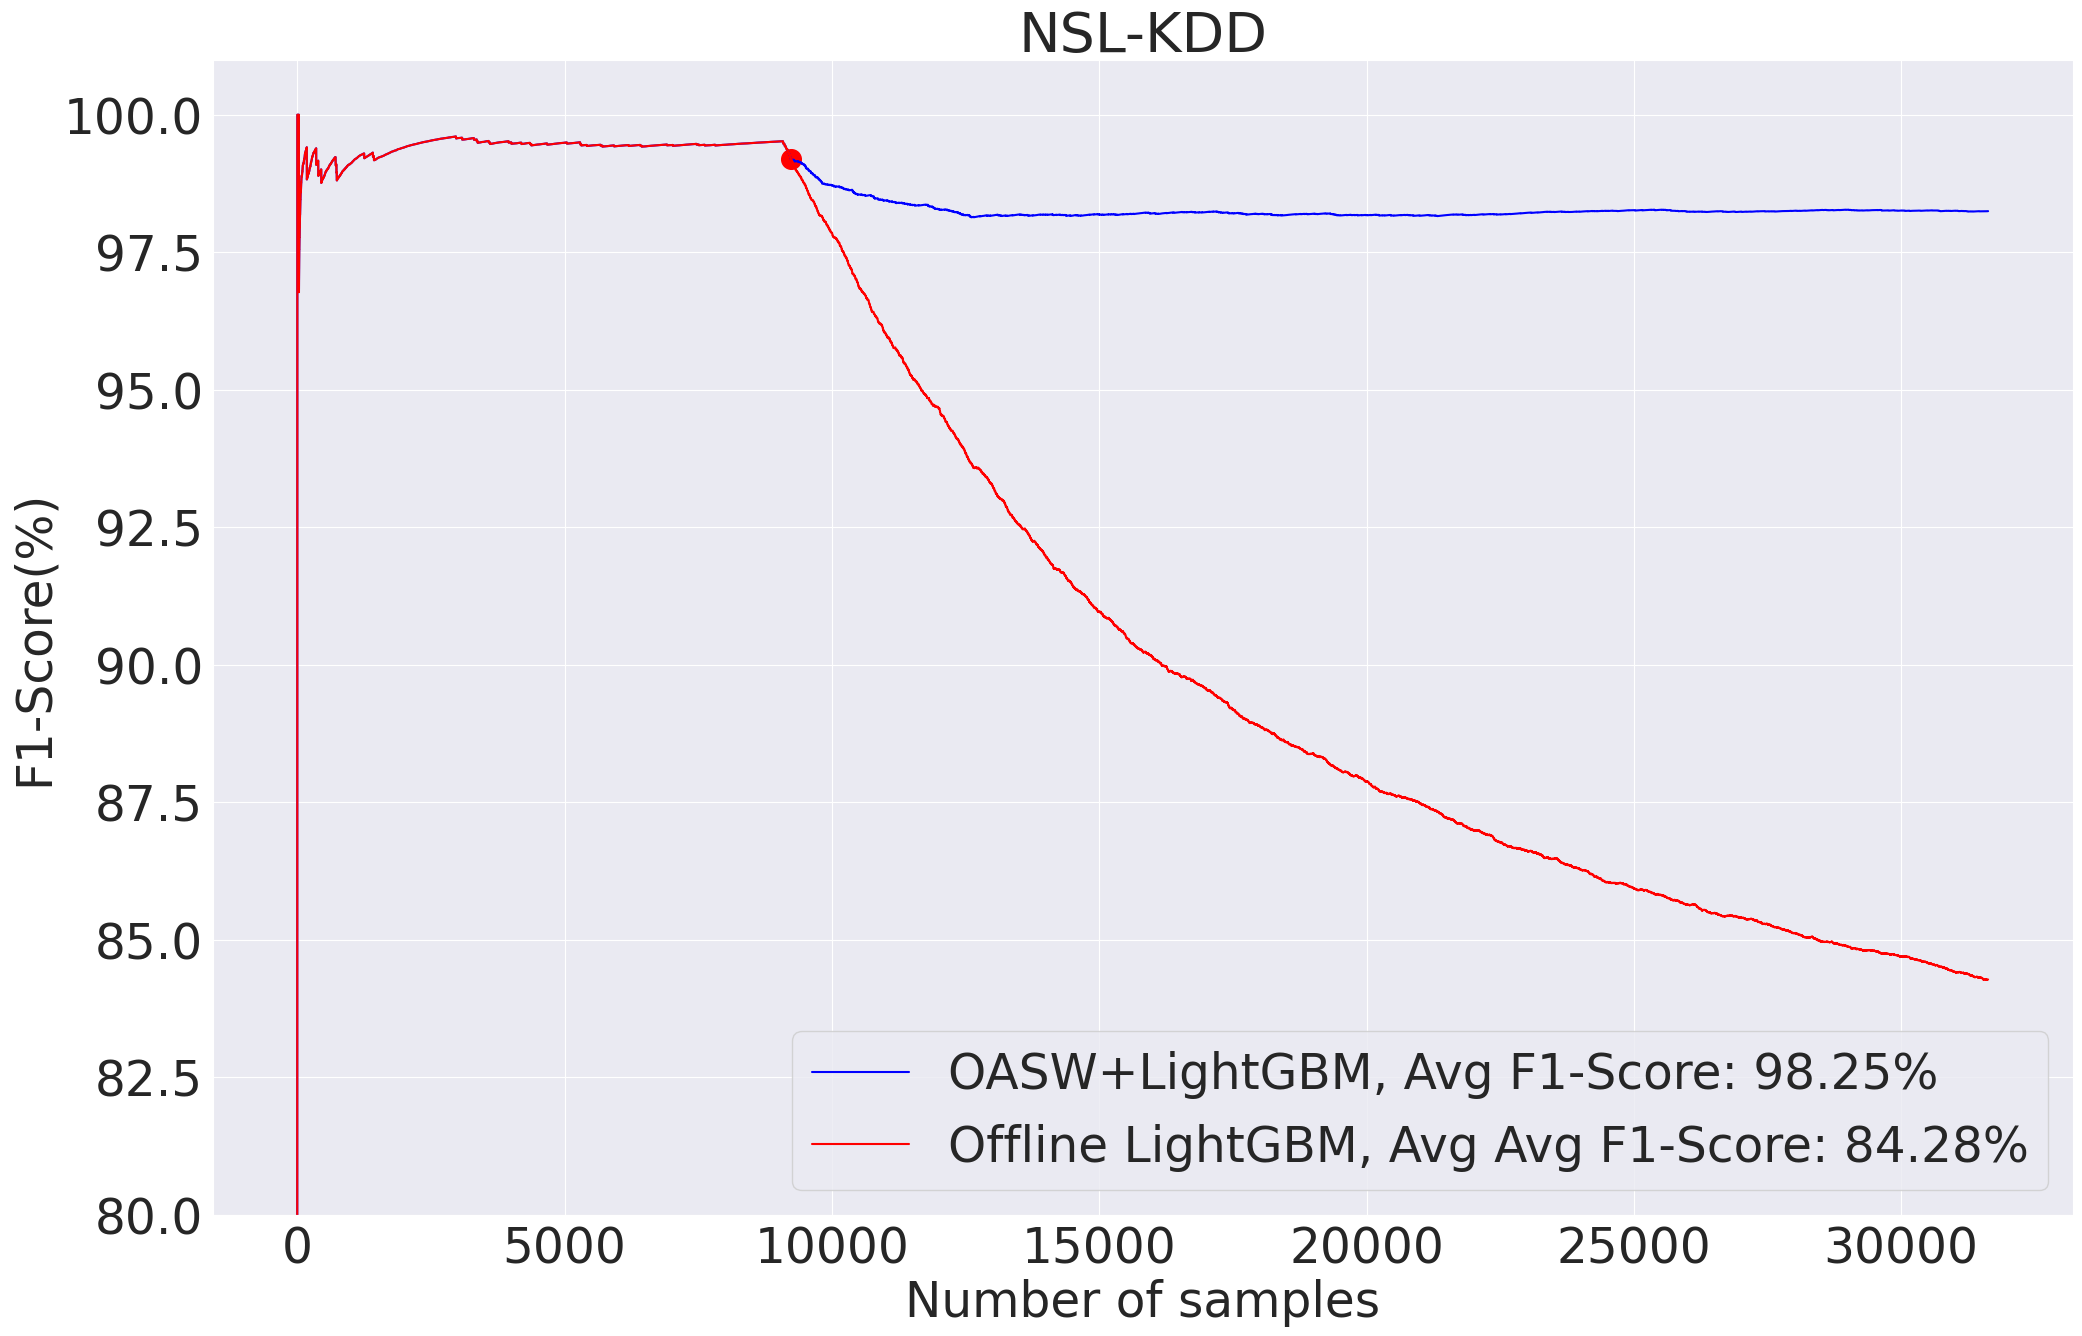

In [32]:
# Assign the optimal hyperparameters detected by PSO
oasw_plot(a = 0.96509765625, b = 0.9200390625, win1 = 344, win2 = 3521)